In [1]:
from datetime import datetime
import os
import tempfile
from glob import glob
from pathlib import Path
this_path = Path().resolve()
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from torch.utils import tensorboard

from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import monai
import torchmetrics
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ResizeWithPadOrCrop,
    RandAdjustContrast,
    RandBiasField,
    RandAffine,
    ScaleIntensity,
)
import pandas as pd
import torchio as tio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml

from dataset.ppmi_dataset import PPMIDataModule
from dataset.hmri_dataset import HMRIDataModule
from models.pl_model import Model
# monai.config.print_config()

/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2023-02-28 16:49:16,735 - Created a temporary directory at /tmp/tmpmnanpfxj
2023-02-28 16:49:16,736 - Writing /tmp/tmpmnanpfxj/_remote_module_non_scriptable.py
/home/alejandrocu/Documents/parkinson_classification/models/medicalnet


In [2]:
# predict with the best model
exp_name = '3dresnet-da00_lrsch_focal_sgd01_rs128'
ckpt_name = 'epoch=39-val_acc=0.8177.ckpt'
exp_dir = Path(this_path / f'outputs/{exp_name}/version_0')
ckpt_path = exp_dir / 'checkpoints' / ckpt_name

with open(exp_dir.parent /'config_dump.yml', 'r') as f:
        cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

print(cfg)

{'aug': 'Compose([])', 'dataset': {'random_state': 70, 'reshape_size': 200, 'train_batch_size': 5, 'train_num_workers': 2, 'val_batch_size': 5, 'val_num_workers': 2}, 'exp_name': '3dresnet-da00_lrsch_focal_sgd01_rs128', 'model': {'in_channels': 1, 'learning_rate': 0.01, 'loss': 'focal', 'n_classes': 2, 'net': '3dresnet', 'optimizer_class': 'sgd', 'sch_patience': 10}, 'pl_trainer': {'accelerator': 'gpu', 'devices': [0], 'log_every_n_steps': 10, 'max_epochs': 50, 'precision': 16}}


In [17]:
# create PPMI dataset

# read metadata file and get the first scan for each subject
root_dir = Path("/mnt/scratch/7TPD/mpm_run_acu/PPMI")
md_df = pd.read_csv(root_dir/'t1_3d_3t_1mm_pdhc_2_16_2023.csv')
md_df['Acq Date'] = md_df['Acq Date'].apply(pd.to_datetime)
md_df.sort_values(by='Acq Date', inplace=True)
first_acq_idx = md_df.duplicated(subset=['Subject'])
md_df_first = md_df.loc[~first_acq_idx, :]

# create dataset
data = PPMIDataModule(md_df=md_df_first, root_dir=root_dir, **cfg['dataset'])
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

# obtain the dataloader
test_dl = data.test_dataloader()
val_dl = data.val_dataloader()
train_dl = data.train_dataloader()

# create model
# model = Model(**cfg['model'])
# model.load_from_checkpoint(ckpt_path, **cfg['model'])
model = Model.load_from_checkpoint(ckpt_path, **cfg['model'])
model.eval()

Training:   288
Validation:  96
Test:       97
loading pretrained model pretrain/resnet_10_23dataset.pth
Pretrained 3D resnet has a single input channel


Model(
  (criterion): BinaryFocalLossWithLogits()
  (train_acc): BinaryAccuracy()
  (val_acc): BinaryAccuracy()
  (train_auroc): BinaryAUROC()
  (val_auroc): BinaryAUROC()
  (train_f1): BinaryF1Score()
  (val_f1): BinaryF1Score()
  (net): ResNet(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momen

#### Train dL

In [4]:
trainer = pl.Trainer(accelerator='gpu') #
predictions_train = trainer.predict(model, dataloaders=train_dl)

2023-02-27 11:10:19,786 - GPU available: True (cuda), used: True
2023-02-27 11:10:19,787 - TPU available: False, using: 0 TPU cores
2023-02-27 11:10:19,788 - IPU available: False, using: 0 IPUs
2023-02-27 11:10:19,788 - HPU available: False, using: 0 HPUs
2023-02-27 11:10:19,790 - You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-02-27 11:10:19,793 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3. ...
  rank_zero_warn(
/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers

Predicting: 0it [00:00, ?it/s]

In [5]:
predictions_train

[tensor([[-3.0490,  3.0291],
         [-2.9815,  3.0837],
         [-4.5817,  4.4686],
         [-3.4305,  3.2872],
         [-3.2221,  3.3926]]),
 tensor([[-4.3788,  4.4709],
         [-3.3644,  3.2800],
         [-2.3720,  2.3687],
         [-0.9099,  0.9694],
         [-2.4703,  2.5830]]),
 tensor([[-2.3461,  2.3748],
         [-2.7814,  2.9124],
         [-2.9362,  2.9038],
         [ 1.9840, -1.9366],
         [-2.9913,  3.1567]]),
 tensor([[-3.8463,  4.0559],
         [-4.0000,  4.1309],
         [-3.1186,  2.8593],
         [-4.7299,  4.6089],
         [-3.7122,  3.6824]]),
 tensor([[ 2.6051, -2.4363],
         [-2.9449,  3.1113],
         [-3.4848,  3.4380],
         [-0.6961,  0.8120],
         [-5.7788,  5.9549]]),
 tensor([[-2.1500,  2.0953],
         [ 2.9356, -2.7078],
         [-3.7565,  3.6918],
         [ 2.5807, -2.3966],
         [-5.1960,  5.2267]]),
 tensor([[-2.5601,  2.6800],
         [ 2.2683, -2.1264],
         [-4.0877,  4.2415],
         [-4.3038,  4.4068],
  

In [6]:
preds = [item for sublist in predictions_train for item in sublist]
preds_sf = [torch.softmax(item, dim=0) for item in preds]
y_hat = [torch.argmax(item).cpu().numpy() for item in preds_sf]

In [7]:
train_labels = [torch.max(item['label'], 0)[1].cpu().numpy() for item in data.train_set]
train_res = pd.DataFrame([train_labels, y_hat]).T
train_res.columns = ['label', 'pred']
train_res['correct'] = train_res['label'] == train_res['pred']
train_res

,label,pred,correct
0,0,1,False
1,0,1,False
2,1,1,True
3,1,1,True
4,0,1,False
...,...,...,...
283,0,1,False
284,0,1,False
285,0,0,True
286,0,1,False


In [8]:
print(train_res['correct'].value_counts())
print(train_res['label'].value_counts())
print(train_res['pred'].value_counts())

False    188
True     100
Name: correct, dtype: int64
0    223
1     65
Name: label, dtype: int64
1    223
0     65
Name: pred, dtype: int64


In [9]:
188/(288)

0.6527777777777778

#### Val dL

In [10]:
trainer = pl.Trainer(accelerator='gpu') #
predictions = trainer.predict(model, dataloaders=val_dl)

2023-02-27 11:21:08,466 - GPU available: True (cuda), used: True
2023-02-27 11:21:08,466 - TPU available: False, using: 0 TPU cores
2023-02-27 11:21:08,466 - IPU available: False, using: 0 IPUs
2023-02-27 11:21:08,467 - HPU available: False, using: 0 HPUs
2023-02-27 11:21:08,468 - You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-02-27 11:21:08,490 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3. ...
  rank_zero_warn(
/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [11]:
predictions

[tensor([[-0.2068,  0.1725],
         [ 0.3278, -0.2846],
         [-2.1050,  2.3348],
         [ 0.2582, -0.0663],
         [-1.7950,  1.7166]]),
 tensor([[-2.3669,  2.3111],
         [-0.0984,  0.1664],
         [-2.1417,  2.1970],
         [-1.3301,  1.4171],
         [-2.3311,  2.4499]]),
 tensor([[-3.0341,  3.0945],
         [-2.1840,  2.0880],
         [-2.4393,  2.5056],
         [-2.7879,  2.7273],
         [-0.8004,  0.8098]]),
 tensor([[-1.9818,  1.9867],
         [-3.2560,  3.2697],
         [-0.0730,  0.1380],
         [-1.1507,  1.2572],
         [-1.9517,  2.0791]]),
 tensor([[-2.6508,  2.6429],
         [-0.3142,  0.2016],
         [-3.4411,  3.3302],
         [ 0.6299, -0.5126],
         [-2.8758,  2.8740]]),
 tensor([[-1.5688,  1.5722],
         [-3.0440,  3.0840],
         [-3.3633,  3.2898],
         [-0.7796,  0.9073],
         [-2.3363,  2.6041]]),
 tensor([[-2.2111,  2.1766],
         [-1.1820,  1.3503],
         [-2.2319,  2.1338],
         [-1.5198,  1.7097],
  

In [12]:
preds = [item for sublist in predictions for item in sublist]
preds_sf = [torch.softmax(item, dim=0) for item in preds]
y_hat = [torch.argmax(item).cpu().numpy() for item in preds_sf]

In [13]:
data.md_df_val

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
713,I287902,3311,PD,M,75,BL,MRI,MPRAGE GRAPPA,Original,2012-01-31,DCM,NaN
446,I368584,3638,PD,M,66,BL,MRI,SAG T1 3D MPRAGE,Original,2013-04-02,DCM,NaN
737,I372986,3191,Control,F,66,BL,MRI,SAG MPRAGE GRAPPA,Original,2013-05-02,DCM,NaN
470,I243291,3610,Control,F,60,BL,MRI,SAG T1 3D MPRAGE,Original,2011-05-24,DCM,NaN
681,I378541,3332,PD,M,74,BL,MRI,MPRAGE GRAPPA,Original,2013-04-23,DCM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
469,I243297,3611,Control,F,42,BL,MRI,SAG T1 3D MPRAGE,Original,2011-05-25,DCM,NaN
399,I337731,3775,PD,M,63,BL,MRI,MPRAGE GRAPPA,Original,2012-05-30,DCM,NaN
94,I554270,40893,PD,M,71,V04,MRI,MPRAGE w/ GRAPPA,Original,2015-03-24,DCM,NaN
967,I1642716,121109,PD,F,57,BL,MRI,MPRAGE,Original,2022-11-03,DCM,NaN


In [14]:
val_labels = [torch.max(item['label'], 0)[1].cpu().numpy() for item in data.val_set]
val_res = pd.DataFrame([val_labels, y_hat]).T
val_res.columns = ['label', 'pred']
val_res['correct'] = val_res['label'] == val_res['pred']
val_res

,label,pred,correct
0,0,1,False
1,0,0,True
2,1,1,True
3,1,0,False
4,0,1,False
...,...,...,...
91,1,1,True
92,0,1,False
93,0,1,False
94,0,1,False


In [15]:
print('correct \n', val_res['correct'].value_counts())
print('labels \n', val_res['label'].value_counts())
print('preds \n', val_res['pred'].value_counts())

correct 
 False    78
True     18
Name: correct, dtype: int64
labels 
 0    74
1    22
Name: label, dtype: int64
preds 
 1    90
0     6
Name: pred, dtype: int64


In [14]:
print('acc', 18/96)

acc 0.1875


### Dev

In [3]:
cfg['dataset']

{'random_state': 70,
 'reshape_size': 200,
 'train_batch_size': 5,
 'train_num_workers': 2,
 'val_batch_size': 5,
 'val_num_workers': 2}

In [58]:
# create PPMI dataset

# read metadata file and get the first scan for each subject
root_dir = Path("/mnt/scratch/7TPD/mpm_run_acu/PPMI")
md_df = pd.read_csv(root_dir/'t1_3d_3t_1mm_pdhc_2_16_2023.csv')
md_df['Acq Date'] = md_df['Acq Date'].apply(pd.to_datetime)
md_df.sort_values(by='Acq Date', inplace=True)
first_acq_idx = md_df.duplicated(subset=['Subject'])
md_df_first = md_df.loc[~first_acq_idx, :]

# create PPMI dataset
augmentations = tio.Compose([                                 
                                    tio.RandomAffine(scales=(0.1, 0.1, 0.1), 
                                                        degrees=(10, 0, 10),
                                                        center='image',
                                                        default_pad_value=0.5),
                                    # tio.RandomElasticDeformation(p=0.1, num_control_points=7, max_displacement=10),
                                    tio.RandomGamma(p=0.5),
                                    tio.RandomNoise(p=1, mean=0.5, std=0.01), # p=0.5]
                                    # tio.RandomMotion(p=0.1), #, degrees=20, translation=20),
                                    # tio.RandomBiasField(p=0.25),
                                    ])


data = PPMIDataModule(md_df=md_df_first, 
                        root_dir=root_dir, 
                        augment=augmentations, 
                        **cfg['dataset'])
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

# obtain the dataloader
test_dl = data.test_dataloader()
val_dl = data.val_dataloader()
train_dl = data.train_dataloader()

Training:   288
Validation:  96
Test:       97


In [59]:
data.transform

Compose([Compose([RescaleIntensity(out_min_max=(0, 1), percentiles=(0, 100), masking_method=None), CropOrPad()]), Compose([RandomAffine(), RandomGamma()])])

<class 'torch.Tensor'> torch.Size([5, 1, 200, 200, 200]) tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]) torch.Size([5, 2])


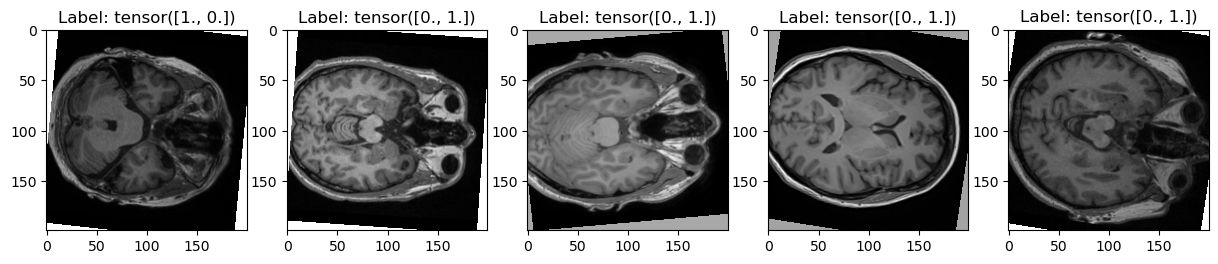

In [60]:
for subjects_batch in train_dl:
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)

f,axs = plt.subplots(1,5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(inputs[i].cpu().detach().numpy()[0, :, :, 100], cmap='gray')
    axs[i].set_title(f'Label: {target[i]}')
# plt.imshow(inputs[2].cpu().detach().numpy()[0, :, :, 70]) # , (1, 2, 3, 0)

In [16]:
def test_model(model, loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    acc = torchmetrics.Accuracy(task='binary')
    auroc = torchmetrics.AUROC(task='binary')
    f1score = torchmetrics.F1Score(task='binary', num_classes=2, average='macro')
    with torch.no_grad():
        labels_all = []
        preds_all = []
        step_acc = {'acc': [], 'auroc': [], 'f1score': []}
        model.net.to_cuda()
        for batch in loader:
            # y_hat, y = model.infer_batch(batch)
            x, y = model.prepare_batch(batch)
            x, y = x.cuda(), y.cuda()
            y_hat = model.net(x)
            # print(y_hat)
            # print(y)
            step_acc['acc'].append(acc(y_hat, y).cpu().numpy())
            step_acc['auroc'].append(auroc(y_hat, y).cpu().numpy())
            step_acc['f1score'].append(f1score(y_hat, y).cpu().numpy())
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(y_hat.data, 1)
            total += y.size(0)
            correct += torch.sum(predicted == torch.max(y.data, 1)[1])
            labels_all.extend(y.cpu().numpy())
            preds_all.extend(predicted.cpu().numpy())
        print(f'Acc: {correct/total}')    
    return labels_all, preds_all, step_acc

In [17]:
val_labels, val_preds, step_acc = test_model(model, val_dl)

AttributeError: 'ResNet' object has no attribute 'to_cuda'

In [75]:
print(np.argmax(val_labels[0]), val_labels[0])

0 [1. 0.]


In [76]:
sum([np.argmax(i) for i in val_labels])

74

In [26]:
val_labels, val_preds = test_model(model, val_dl)

tensor([[ 2.0421e-14, -2.2780e-13],
        [ 3.2509e-14, -1.8618e-13],
        [ 1.5679e-14, -1.4702e-13],
        [ 1.7819e-14, -1.7926e-13],
        [ 2.7635e-14, -1.9061e-13]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor(0.5000)


In [46]:
val_labels.size(0)

5

In [40]:
_, predicted = torch.max(val_preds.data, 1)
print(predicted)

tensor([0, 0, 0, 0, 0])


In [44]:
torch.max(val_labels.data, 1)[1]

tensor([0, 0, 0, 0, 1])

In [45]:
torch.sum(predicted == torch.max(val_labels.data, 1)[1])

tensor(4)

In [32]:
torch.softmax(val_preds, dim=1)

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]])

In [59]:
for subjects_batch in val_dl:
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)

<class 'torch.Tensor'> torch.Size([5, 1, 128, 128, 128]) tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]]) torch.Size([5, 2])


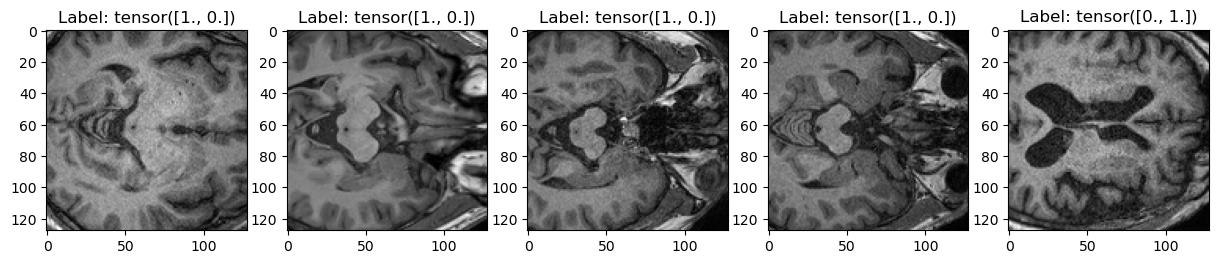

In [65]:
f,axs = plt.subplots(1,5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(inputs[i].cpu().detach().numpy()[0, :, :, 70], cmap='gray')
    axs[i].set_title(f'Label: {target[i]}')
# plt.imshow(inputs[2].cpu().detach().numpy()[0, :, :, 70]) # , (1, 2, 3, 0)

### hMRI Dataset

In [3]:
# Set data directory
data_path = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'Data - PD: {pd_number}, HC: {hc_number}')

Data - PD: 49, HC: 23


In [9]:
augmentations = tio.Compose([])
data = HMRIDataModule(md_df=md_df,
                        root_dir=data_path,
                        augment=augmentations,
                        **cfg['dataset'])
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

Drop subject 058 because it doesn't have maps
Training:   42
Validation:  14
Test:       15


In [7]:
data.train_set[0]['image']

ScalarImage(shape: (4, 200, 200, 200); spacing: (1.00, 1.00, 1.00); orientation: PSR+; dtype: torch.FloatTensor; memory: 122.1 MiB)

In [11]:
for subjects_batch in data.train_dataloader():
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)


<class 'torch.Tensor'> torch.Size([5, 4, 200, 200, 200]) tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]]) torch.Size([5, 2])


In [17]:
inputs[0].squeeze().shape

torch.Size([4, 200, 200, 200])

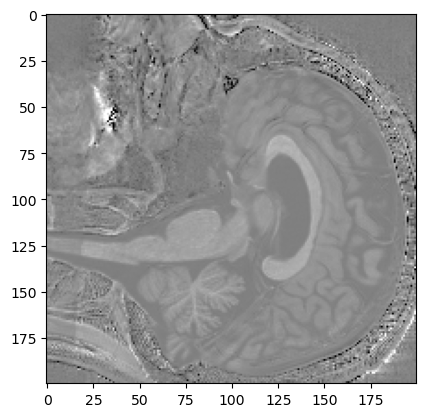

In [18]:
plt.imshow(inputs[0][0, :, :, 100], cmap='gray')

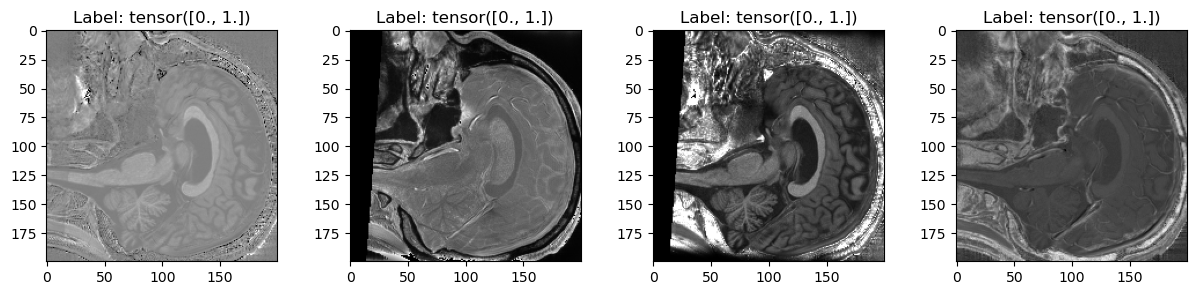

In [12]:
f,axs = plt.subplots(1,4, figsize=(15, 3))
for i in range(4):
    axs[i].imshow(inputs[0].cpu().detach().numpy()[i, :, :, 100], cmap='gray')
    axs[i].set_title(f'Label: {target[0]}')

In [12]:
subjects_list = []
subjects_labels = []
for i in range(len(md_df)):
    subj_dir = data_path / md_df.loc[i, 'id'] / 'Results'
    hmri_files = sorted(list(subj_dir.glob('*.nii')), key=lambda x: x.stem)
    subjects_list.append(hmri_files)
    subjects_labels.append(md_df.loc[i, 'group'])

In [ ]:
for i in range(len(md_df)):
    subj_dir = data_path / md_df.loc[i, 'id'] / 'Results'
    hmri_files = sorted(list(subj_dir.glob('*.nii')), key=lambda x: x.stem)
    break
print(hmri_files)

[PosixPath('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/sub-003/Results/sub-003_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_MTsat.nii'), PosixPath('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/sub-003/Results/sub-003_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_PD_R2scorr.nii'), PosixPath('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/sub-003/Results/sub-003_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_R1.nii'), PosixPath('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/sub-003/Results/sub-003_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_R2s_WLS1.nii')]


### Checking orientations

In [3]:
augmentations = tio.Compose([])

# create PPMI dataset

# read metadata file and get the first scan for each subject
root_dir = Path("/mnt/scratch/7TPD/mpm_run_acu/PPMI")
md_df = pd.read_csv(root_dir/'t1_3d_3t_1mm_pdhc_2_16_2023.csv')
md_df['Acq Date'] = md_df['Acq Date'].apply(pd.to_datetime)
md_df.sort_values(by='Acq Date', inplace=True)
first_acq_idx = md_df.duplicated(subset=['Subject'])
md_df_first = md_df.loc[~first_acq_idx, :]

# create dataset
data = PPMIDataModule(md_df=md_df_first, 
                      root_dir=root_dir, 
                      augment=augmentations, 
                      **cfg['dataset'])
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

ppmi_val_dl = data.val_dataloader()

# Set data directory
data_path = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

data_hmri = HMRIDataModule(md_df=md_df,
                        root_dir=data_path,
                        augment=augmentations,
                        **cfg['dataset'])
data_hmri.prepare_data()
data_hmri.setup()
print("Training:  ", len(data_hmri.train_set))
print("Validation: ", len(data_hmri.val_set))
print("Test:      ", len(data_hmri.test_set))

hmri_val_dl = data_hmri.val_dataloader()

Training:   288
Validation:  96
Test:       97
------------
 Data - PD: 49, HC: 23
Drop subject 058 because it doesn't have maps
Training:   42
Validation:  14
Test:       15


In [5]:
for subjects_batch in ppmi_val_dl:
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)

<class 'torch.Tensor'> torch.Size([5, 1, 200, 200, 200]) tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]]) torch.Size([5, 2])


In [6]:
data.train_subjects[0]['image']

ScalarImage(shape: (1, 176, 240, 256); spacing: (1.00, 1.00, 1.00); orientation: RAS+; path: "/mnt/scratch/7TPD/mpm_run_acu/PPMI/3825/MPRAGE_GRAPPA/2012-07-03_10_36_56.0/S157163/PPMI_3825_MR_MPRAGE_GRAPPA__br_raw_20120710135828029_131_S157163_I315739.nii")

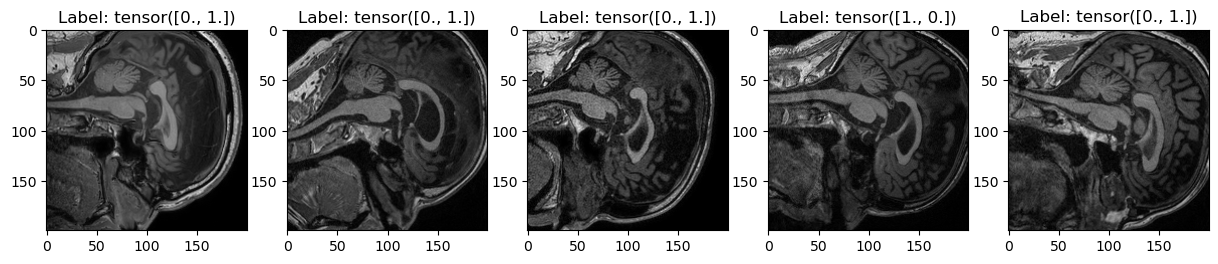

In [9]:
f,axs = plt.subplots(1,5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(inputs[i].cpu().detach().numpy()[0, 100, :, :], cmap='gray')
    axs[i].set_title(f'Label: {target[i]}')

In [4]:
for subjects_batch in hmri_val_dl:
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)

<class 'torch.Tensor'> torch.Size([5, 4, 200, 200, 200]) tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]]) torch.Size([5, 2])


In [5]:
data_hmri.train_subjects[0]['image']

ScalarImage(shape: (4, 240, 256, 176); spacing: (1.00, 1.00, 1.00); orientation: PSR+; dtype: torch.FloatTensor; memory: 165.0 MiB)

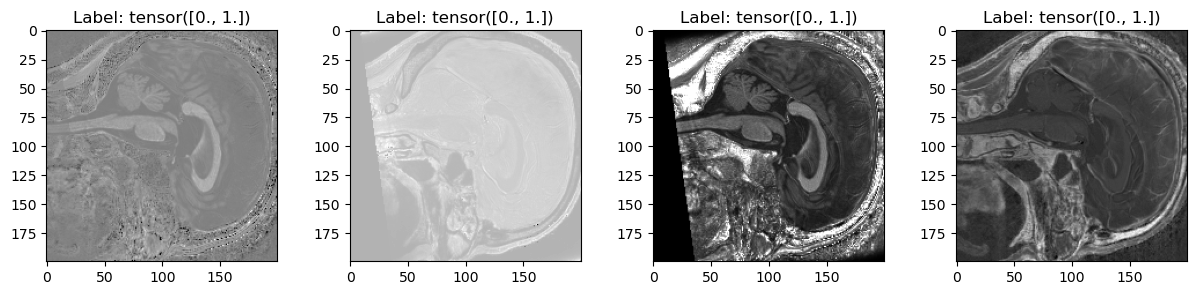

In [8]:
subj = 0
f,axs = plt.subplots(1,4, figsize=(15, 3))
for i in range(4):
    axs[i].imshow(inputs[subj].cpu().detach().numpy()[i, 100, :, :], cmap='gray')
    axs[i].set_title(f'Label: {target[subj]}')